I wrote two methods for the NEMO reader

1. NEMO_native_linearindex - Based on the ROMS_native reader - assumes a linear relationship between grid index and lat/lon positions - this doesn't hold for some of the NEMO models.
2. NEMO_native_interpolate - Identifies indices in a neighbourhood around desired positions and then interpolates everything to a regular lat/lon grid. This is essentially how the flattened NEMO files are handled now.

This notebook compares the two methods.

In [1]:
import glob
import os
import datetime

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from opendrift.models.oceandrift import OceanDrift
from opendrift.readers import reader_NEMO_native_interpolate, reader_NEMO_native_linearindex

In [2]:
CIOPSW3D='/home/soontiensn/data/opendrift_test_data/CIOPSW/3D/'
CIOPSW2D='/home/soontiensn/data/opendrift_test_data/CIOPSW/2D/'
CIOPSW_mesh='/home/soontiensn/data/opendrift_test_data/CIOPSW/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc'
CIOPSW3D_mapping={'vo': 'y_sea_water_velocity', 'uo': 'x_sea_water_velocity', 'time_counter': 'time'}
CIOPSW2D_mapping={'vos': 'y_sea_water_velocity', 'uos': 'x_sea_water_velocity', 'time_counter': 'time'}


# Middle of ocean
Do the interpolation methods match in the middle of the ocean??

Plan:

Look up variables at a grid point.
Idenitfy the lat/lon of the grid point
Look up readers interpolated variable at that lat/lon.
Do they match? How nuch do they differ?

In [3]:
j,i = 200, 500

## reader_NEMO_native_interpolate

In [4]:
reader = reader_NEMO_native_interpolate.Reader(os.path.join(CIOPSW3D, '*.nc'),
                                  meshfile=CIOPSW_mesh, variable_mapping=CIOPSW3D_mapping,
                                  rotation_pickle_file='CIOPSW_angles.pickle', model_land_mask=True)
reader

Reader: NEMO native
Projection: 
  +proj=latlong
Coverage: [degrees]
  xmin: -142.283173   xmax: -120.568398   step: 0.0264286   numx: 822
  ymin: 44.333385   ymax: 59.621494   step: 0.013255   numy: 1154
  Corners (lon, lat):
    (-142.28,  59.62)  (-120.57,  59.62)
    (-142.28,  44.33)  (-120.57,  44.33)
Vertical levels [m]: 
  [   0.50753002    1.55756949    2.66934092    3.85788494    5.14191383
    6.54453533    8.09397147    9.82415767   11.77504435   13.99236471
   16.52661505   19.43106879   22.75886112   26.55953148   30.87578506
   35.74142753   41.18125371   47.21313512   53.8518956    61.11412039
   69.0229896    77.61249606   86.93079064   97.04271073  108.03171341
  120.00146911  133.07732682  147.40778644  163.16603545  180.55153922
  199.79161551  221.14287375  244.892354    271.35815779  300.88932529
  333.86468319  370.69037225  411.79577221  457.62758321  508.64190847
  565.29431754  628.02805354  697.26076989  773.37042023  856.68114272
  947.45013658 1045.85658048

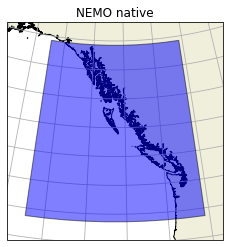

In [5]:
reader.plot()

In [6]:
lons = reader.lon
lats = reader.lat
land_binary_mask = reader.land_binary_mask

lon = lons[j,i]
lat = lats[j,i]

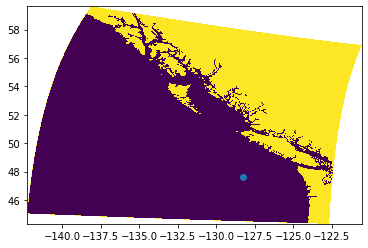

In [7]:
fig,ax = plt.subplots(1,1)
ax.pcolormesh(lons,lats, land_binary_mask)
ax.plot(lon,lat, 'o')

In [8]:
vmapping={'x_sea_water_velocity': 'uo', 'y_sea_water_velocity': 'vo', 'land_binary_mask': 'land_binary_mask'}
# Real values
reals={}
for v in vmapping:
    vnemo =vmapping[v]
    tmp=reader.Dataset.variables[vnemo][...,j,i]
    if tmp.ndim > 1:
        tmp = tmp[0,0]
    reals[v] = tmp.values

In [9]:
interps = reader.get_variables_interpolated(['x_sea_water_velocity', 'y_sea_water_velocity', 'land_binary_mask'],
                                  time=reader.start_time,
                                  lon=lon,
                                  lat=lat)
interps

({'x_sea_water_velocity': masked_array(data=[0.06239086],
               mask=False,
         fill_value=1e+20),
  'y_sea_water_velocity': masked_array(data=[-0.02228735],
               mask=False,
         fill_value=1e+20),
  'land_binary_mask': array([0.])},
 None)

# Reader_NEMO_native_linearindex

In [10]:
reader = reader_NEMO_native_linearindex.Reader(os.path.join(CIOPSW3D, '*.nc'),
                                  meshfile=CIOPSW_mesh, variable_mapping=CIOPSW3D_mapping,
                                  rotation_pickle_file='CIOPSW_angles.pickle', model_land_mask=True)
reader

No proj string or projection could be derived, using 'fakeproj'. This assumes that the variables are structured and gridded approximately equidistantly on the surface (i.e. in meters). This must be guaranteed by the user. You can get rid of this warning by suppling a valid projection to the reader.


Reader: NEMO native
Projection: 
  None
Coverage: [pixels]
  xmin: 0.000000   xmax: 713.000000   step: 1   numx: 714
  ymin: 0.000000   ymax: 1019.000000   step: 1   numy: 1020
  Corners (lon, lat):
    (-138.12,  59.62)  (-120.57,  56.90)
    (-142.28,  45.05)  (-122.69,  44.33)
Vertical levels [m]: 
  [   0.50753002    1.55756949    2.66934092    3.85788494    5.14191383
    6.54453533    8.09397147    9.82415767   11.77504435   13.99236471
   16.52661505   19.43106879   22.75886112   26.55953148   30.87578506
   35.74142753   41.18125371   47.21313512   53.8518956    61.11412039
   69.0229896    77.61249606   86.93079064   97.04271073  108.03171341
  120.00146911  133.07732682  147.40778644  163.16603545  180.55153922
  199.79161551  221.14287375  244.892354    271.35815779  300.88932529
  333.86468319  370.69037225  411.79577221  457.62758321  508.64190847
  565.29431754  628.02805354  697.26076989  773.37042023  856.68114272
  947.45013658 1045.85658048 1151.99356275 1265.86377385

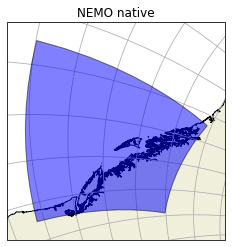

In [11]:
reader.plot()

In [12]:
lons = reader.lon
lats = reader.lat
land_binary_mask = reader.land_binary_mask

lon = lons[j,i]
lat = lats[j,i]

In [13]:
vmapping={'x_sea_water_velocity': 'uo', 'y_sea_water_velocity': 'vo', 'land_binary_mask': 'land_binary_mask'}
# Real values
reals={}
for v in vmapping:
    vnemo =vmapping[v]
    tmp=reader.Dataset.variables[vnemo][...,j,i]
    if tmp.ndim > 1:
        tmp = tmp[0,0]
    reals[v] = tmp.values
reals

{'x_sea_water_velocity': array(0.06387585),
 'y_sea_water_velocity': array(-0.01779792),
 'land_binary_mask': array(0.)}

In [24]:
interps = reader.get_variables_interpolated(['x_sea_water_velocity', 'y_sea_water_velocity', 'land_binary_mask'],
                                  time=reader.start_time,
                                  lon=lon,
                                  lat=lat)
interps

({'x_sea_water_velocity': masked_array(data=[0.06239651],
               mask=False,
         fill_value=1e+20),
  'y_sea_water_velocity': masked_array(data=[-0.02231832],
               mask=False,
         fill_value=1e+20),
  'land_binary_mask': array([0.])},
 None)